# Airplane, Leopard, or Dolphin?

### Using the Visual Bag of Word Technique to determine the subject of a photo

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import cv2
import os
import random
from scipy.spatial.distance import cdist
from scipy import stats
from sklearn import svm

# Reads all images in given directory
def read_images(image_dir, N=None, resize_val=None):
    img_names = os.listdir(image_dir)
    M = len(img_names)
    imgs = list()
    if (N is not None):
        img_names = img_names[:N]
    
    for i, img_name in enumerate(img_names):
        img_file = os.path.join(image_dir, img_name)
        img = cv2.imread(img_file)
        if img is not None:
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            if (resize_val is not None):
                img_gray = cv2.resize(img_gray, (0, 0), fx=0.5, fy=0.5)
            imgs.append(img_gray)
        
    return imgs

airplanes = read_images('..\\OIDv4_ToolKit\\OID\\Dataset\\train\\Airplane', resize_val=0.5, N=600)
dolphins = read_images('..\\OIDv4_ToolKit\\OID\\Dataset\\train\\Dolphin', resize_val=0.5, N=600)
leopards = read_images('..\\OIDv4_ToolKit\\OID\\Dataset\\train\\Leopard', resize_val=0.5, N=600)

In [3]:
def plot_img_and_keypoints(img):
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 10))
    ax1.imshow(img, cmap='gray')
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    img_kp = cv2.drawKeypoints(img, kp, img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    ax2.imshow(img_kp)

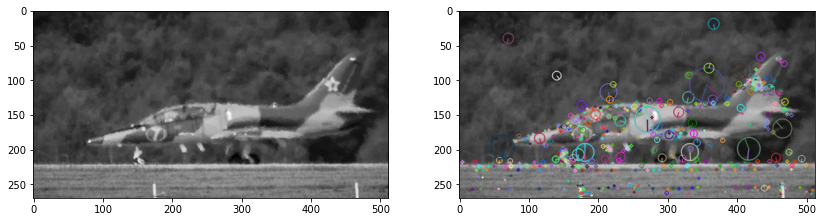

In [4]:
plot_img_and_keypoints(airplanes[4])

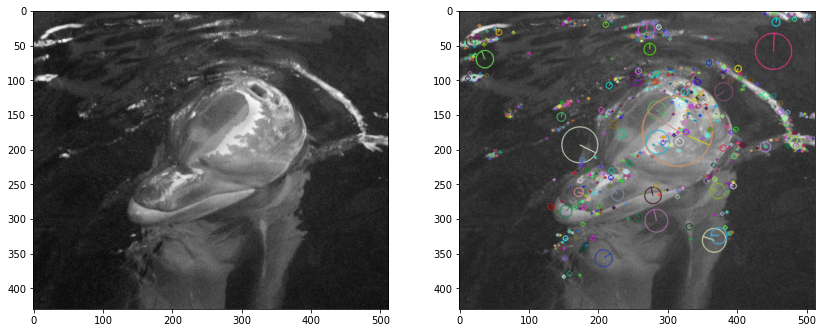

In [5]:
plot_img_and_keypoints(dolphins[0])

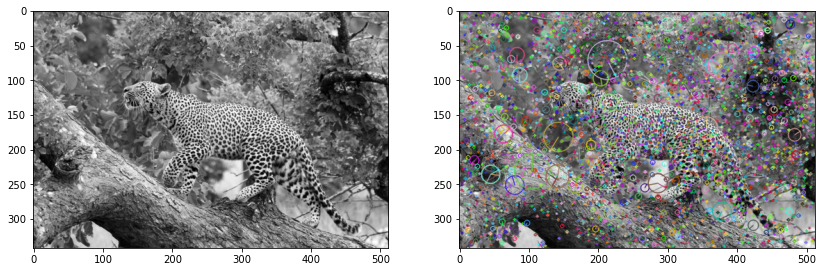

In [6]:
plot_img_and_keypoints(leopards[1])

In [7]:
sift = cv2.SIFT_create()

def get_set_descriptors(image_set, sift, min_kps=70):
    image_set_filtered = []
    keypoints = []
    descips = []
    for img in image_set:
        kp, des = sift.detectAndCompute(img,None)
        if (len(kp) > min_kps):
            image_set_filtered.append(img)
            descips.append(des)
            keypoints.append(kp)
    
    return image_set_filtered, keypoints, descips
        
airplanes_imgs, airplanes_kp, airplanes_des = get_set_descriptors(airplanes, sift)
dolphins_imgs, dolphins_kp, dolphins_des = get_set_descriptors(dolphins, sift)
leopards_imgs, leopards_kp, leopards_des = get_set_descriptors(leopards, sift)

In [8]:
print(len(airplanes_imgs), len(dolphins_imgs), len(leopards_imgs))
print(min(map(len, airplanes_kp)), min(map(len, dolphins_kp)), min(map(len, leopards_kp)))

563 579 600
72 72 108


In [9]:
def argsort(seq):
    # http://stackoverflow.com/questions/3071415/efficient-method-to-calculate-the-rank-vector-of-a-list-in-python
    return sorted(range(len(seq)), key=seq.__getitem__)[::-1]

def get_top_kp_desc(keypoints, descriptors, n):
    top_kp = []
    top_desc = []
    for keypoint, descriptor in zip(keypoints, descriptors):
        kp_sorted_idx = argsort([kp.size for kp in keypoint])
        top_kp_idx = kp_sorted_idx[:n]
        top_kp.append([keypoint[i] for i in top_kp_idx])
        top_desc.append(descriptor[top_kp_idx,:])
    return top_kp, top_desc

min_kp = 65
kpa, desca = get_top_kp_desc(airplanes_kp, airplanes_des, min_kp)
kpd, descd = get_top_kp_desc(dolphins_kp, dolphins_des, min_kp)
kpl, descl = get_top_kp_desc(leopards_kp, leopards_des, min_kp)

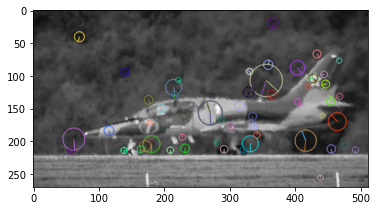

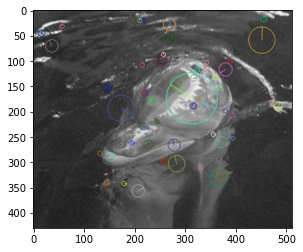

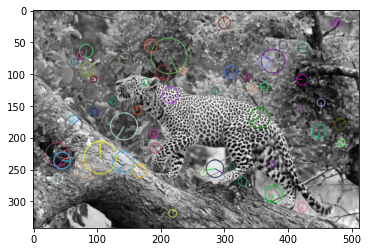

In [10]:
imga=cv2.drawKeypoints(airplanes[4],kpa[4],airplanes[4],flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imgd=cv2.drawKeypoints(dolphins[0], kpd[0],dolphins[0],flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imgl=cv2.drawKeypoints(leopards[1], kpl[1],leopards[1],flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(imga)
plt.show()
plt.imshow(imgd)
plt.show()
plt.imshow(imgl)

In [26]:
train_size = 400
desca_train, desca_test, kpa_train, kpa_test, imga_train, imga_test = train_test_split(desca, kpa, airplanes_imgs, train_size=train_size)
descd_train, descd_test, kpd_train, kpd_test, imgd_train, imgd_test = train_test_split(descd, kpd, dolphins_imgs, train_size=train_size)
descl_train, descl_test, kpl_train, kpl_test, imgl_train, imgl_test  = train_test_split(descl, kpl, leopards_imgs, train_size=train_size)
print(len(desca_train), len(desca_test))
print(len(descd_train), len(descd_test))
print(len(descl_train), len(descl_test))

400 163
400 179
400 200


C:\Users\mills\anaconda3\envs\cmsc426\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [15]:
desca_train_flat = np.vstack(desca_train)
descd_train_flat = np.vstack(descd_train)
descl_train_flat = np.vstack(descl_train)
desca_test_flat = np.vstack(desca_test)
descd_test_flat = np.vstack(descd_test)
descl_test_flat = np.vstack(descl_test)

In [16]:
train_set = np.concatenate((desca_train_flat, descd_train_flat, descl_train_flat))
test_set = np.concatenate((desca_test_flat, descd_test_flat, descl_test_flat))
# Print shape for check
print(train_set.shape)
print(test_set.shape)

(78000, 128)
(35230, 128)


In [18]:
kmeans = KMeans(n_clusters=300, max_iter=100)
train_labels = kmeans.fit_predict(train_set)

C:\Users\mills\anaconda3\envs\cmsc426\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [37]:
img_class_label = {'airplane': 0, 'dolphin': 1, 'leopard': 2}

def get_img_cluster_labels(labels, img_class, img_num, img_per_class, kp_per_img):
    img_class_num = img_class_label.get(img_class)
    if img_class_num is None or img_num > img_per_class:
        raise ValueError('Bad arguments')
    start_idx = img_class_num * img_per_class + img_num * kp_per_img
    end_idx = start_idx + kp_per_img
    return labels[start_idx:end_idx]

<BarContainer object of 52 artists>

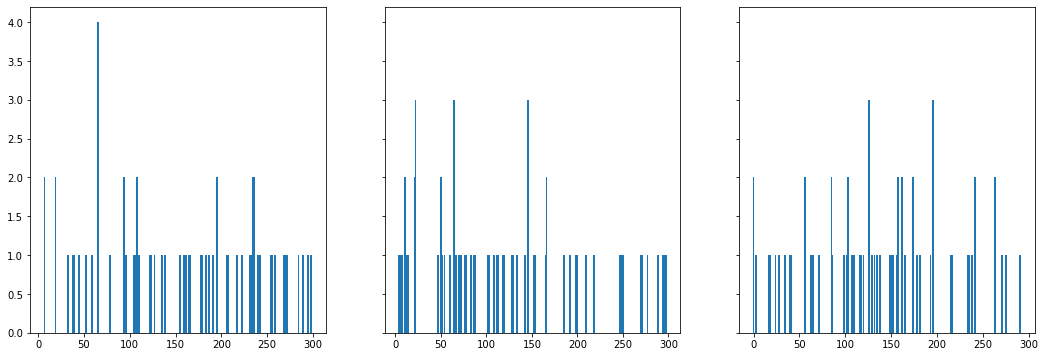

In [56]:
img1_labels = get_img_cluster_labels(train_labels, 'airplane', 4, train_size, min_kp)
img1_hist = np.unique(img1_labels, return_counts=True)
img2_labels = get_img_cluster_labels(train_labels, 'dolphin', 0, train_size, min_kp)
img2_hist = np.unique(img2_labels, return_counts=True)
img3_labels = get_img_cluster_labels(train_labels, 'leopard', 1, train_size, min_kp)
img3_hist = np.unique(img3_labels, return_counts=True)

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
ax1.bar(img1_hist[0], img1_hist[1], width=2)
ax2.bar(img2_hist[0], img2_hist[1], width=2)
ax3.bar(img3_hist[0], img3_hist[1], width=2)

In [52]:
# Returns the area around the keypoint closest to it's cluster's centroid
def get_cluster_images(centroids, labels, images, )

array([146, 218,  14, ...,  32, 140, 193])